In [130]:
# Prabhat Thakur  Date 11/17/2018
# MSDS422 - Assignment-7 
# Image Processing with a CNN DogsVsCats
# The case data present a binary classification task, a subset of the data from a Kaggle competition in 2013

In [131]:
from __future__ import division, print_function, unicode_literals

# Common imports for our work
import os 
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


RANDOM_SEED = 9999
n_epochs = 20
batch_size = 50

data_set = []
train_loss = []
train_accuracy = []
test_accuracy = []

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# for display of images
def show_grayscale_image(image,label):  #Grayscale Image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(label)
    plt.show()

def show_color_image(image,label): # Color Image
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis('off')
    plt.title(label)
    plt.show()

def read_image_files (catsfile,dogsfile,imagetype): # Read Cats and Dogs image files
    # Read in cats and dogs grayscale 64x64 files to create training data
    cats_1000 = np.load(catsfile)
    dogs_1000 = np.load(dogsfile)

    # Examine first cat and first dog grayscale images
    if imagetype == 'gray':
        print (show_grayscale_image(cats_1000[0,:,:,0],'cat'))
        print (show_grayscale_image(dogs_1000[0,:,:,0],'dog'))
    else: 
        print (show_color_image(cats_1000[0,:,:,0],'cat'))
        print (show_color_image(dogs_1000[0,:,:,0],'dog'))
        

    # Work the data for cats and dogs numpy arrays 
    X_cat_dog = np.concatenate((cats_1000, dogs_1000), axis = 0) 

    height1 = X_cat_dog.shape[1]
    width1 = X_cat_dog.shape[2]
    channels1 = X_cat_dog.shape[3]
    print ('Shape: ', X_cat_dog.shape)
    
    X_cat_dog = X_cat_dog.reshape(-1,width1*height1*channels1)
    
    # Scikit Learn for min-max scaling of the data
    scaler = MinMaxScaler()
    scaler.fit(np.array([0., 255.]).reshape(-1,1)) 
    X_cat_dog_min_max = scaler.transform(X_cat_dog)

    # Define the labels to be used 1000 cats = 0 1000 dogs = 1
    y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)


    # Scikit Learn for random splitting of the data  
    # Random splitting of the data in to training (80%) and test (20%)  
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, random_state = RANDOM_SEED)
    
    return X_train1, X_test1, y_train1, y_test1, height1, width1, channels1

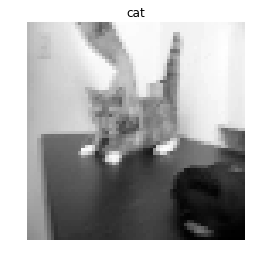

None


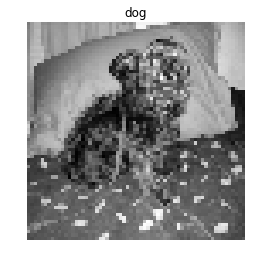

None
Shape:  (2000, 64, 64, 1)
0 Train accuracy:0.58000, Training Loss= 0.685496
Testing Accuracy: 0.48000
1 Train accuracy:0.62000, Training Loss= 0.687577
Testing Accuracy: 0.48750
2 Train accuracy:0.58000, Training Loss= 0.669716
Testing Accuracy: 0.48000
3 Train accuracy:0.60000, Training Loss= 0.642480
Testing Accuracy: 0.48000
4 Train accuracy:0.80000, Training Loss= 0.638989
Testing Accuracy: 0.60250
5 Train accuracy:0.60000, Training Loss= 0.569120
Testing Accuracy: 0.51750
6 Train accuracy:0.82000, Training Loss= 0.515628
Testing Accuracy: 0.56500
7 Train accuracy:0.80000, Training Loss= 0.454029
Testing Accuracy: 0.59750
8 Train accuracy:0.84000, Training Loss= 0.379895
Testing Accuracy: 0.62750
9 Train accuracy:0.90000, Training Loss= 0.311889
Testing Accuracy: 0.64500
10 Train accuracy:0.92000, Training Loss= 0.248562
Testing Accuracy: 0.65250
11 Train accuracy:0.94000, Training Loss= 0.202755
Testing Accuracy: 0.65750
12 Train accuracy:0.98000, Training Loss= 0.160089
Test

In [132]:
#Model 1 using cats and dogs grayscale 64x64
filepath_cats = 'cats_dogs_64-128/cats_1000_64_64_1.npy'
filepath_dog = 'cats_dogs_64-128/dogs_1000_64_64_1.npy'
imagetype = 'gray'

X_train, X_test, y_train, y_test, height, width ,channels = \
                    read_image_files(catsfile = filepath_cats, dogsfile = filepath_dog, imagetype = imagetype)


n_inputs = height * width * channels
n_outputs = 2

conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps*64*4

n_fc1 = 64


reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

    # define variables
tf.InteractiveSession()


with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]  
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Train accuracy:" +  "{:.5f}".format(acc_train) + ", Training Loss= " + "{:.6f}".format(loss_train))
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Testing Accuracy:","{:.5f}".format(acc_test))

    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    train_accuracy.append(acc_train)
    train_loss.append(loss_train)
    test_accuracy.append(acc_test)
    data_set.append('Gray_64x64')


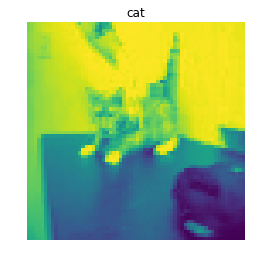

None


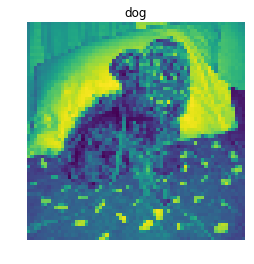

None
Shape:  (2000, 64, 64, 3)
0 Train accuracy:0.58000, Training Loss= 0.679266
Testing Accuracy: 0.48000
1 Train accuracy:0.58000, Training Loss= 0.668660
Testing Accuracy: 0.48000
2 Train accuracy:0.58000, Training Loss= 0.636062
Testing Accuracy: 0.49500
3 Train accuracy:0.70000, Training Loss= 0.561487
Testing Accuracy: 0.60500
4 Train accuracy:0.76000, Training Loss= 0.505862
Testing Accuracy: 0.63250
5 Train accuracy:0.82000, Training Loss= 0.446727
Testing Accuracy: 0.64000
6 Train accuracy:0.80000, Training Loss= 0.390951
Testing Accuracy: 0.65000
7 Train accuracy:0.88000, Training Loss= 0.315033
Testing Accuracy: 0.66500
8 Train accuracy:0.88000, Training Loss= 0.255001
Testing Accuracy: 0.66000
9 Train accuracy:0.90000, Training Loss= 0.196903
Testing Accuracy: 0.66750
10 Train accuracy:0.94000, Training Loss= 0.154430
Testing Accuracy: 0.66750
11 Train accuracy:0.92000, Training Loss= 0.151913
Testing Accuracy: 0.66000
12 Train accuracy:0.92000, Training Loss= 0.185067
Test

In [133]:
#Model 2 using cats and dogs color 64x64
filepath_cats = 'cats_dogs_64-128/cats_1000_64_64_3.npy'
filepath_dog = 'cats_dogs_64-128/dogs_1000_64_64_3.npy'
imagetype = 'color'

X_train, X_test, y_train, y_test, height, width ,channels = read_image_files(catsfile = filepath_cats, dogsfile = filepath_dog, imagetype = imagetype)

n_inputs = height * width*channels
n_outputs = 2

conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps*64*4

n_fc1 = 64


reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

    # define variables
tf.InteractiveSession()


with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]  
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Train accuracy:" +  "{:.5f}".format(acc_train) + ", Training Loss= " + "{:.6f}".format(loss_train))
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Testing Accuracy:","{:.5f}".format(acc_test))

    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    train_accuracy.append(acc_train)
    train_loss.append(loss_train)
    test_accuracy.append(acc_test)
    data_set.append('Color_64x64')


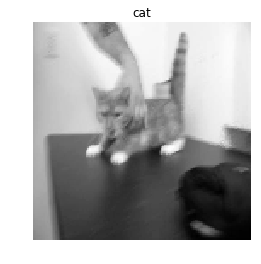

None


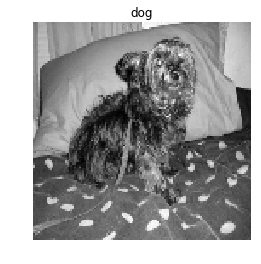

None
Shape:  (2000, 128, 128, 1)
0 Train accuracy:0.60000, Training Loss= 0.647710
Testing Accuracy: 0.52750
1 Train accuracy:0.78000, Training Loss= 0.559616
Testing Accuracy: 0.62250
2 Train accuracy:0.90000, Training Loss= 0.427854
Testing Accuracy: 0.61750
3 Train accuracy:0.88000, Training Loss= 0.333472
Testing Accuracy: 0.62000
4 Train accuracy:0.90000, Training Loss= 0.253639
Testing Accuracy: 0.64250
5 Train accuracy:1.00000, Training Loss= 0.173549
Testing Accuracy: 0.62500
6 Train accuracy:0.98000, Training Loss= 0.152697
Testing Accuracy: 0.67250
7 Train accuracy:1.00000, Training Loss= 0.136846
Testing Accuracy: 0.66500
8 Train accuracy:0.96000, Training Loss= 0.168968
Testing Accuracy: 0.58750
9 Train accuracy:0.98000, Training Loss= 0.093387
Testing Accuracy: 0.57750
10 Train accuracy:1.00000, Training Loss= 0.042571
Testing Accuracy: 0.61750
11 Train accuracy:1.00000, Training Loss= 0.041834
Testing Accuracy: 0.62750
12 Train accuracy:1.00000, Training Loss= 0.029450
Te

In [134]:
#Model 3 using cats and dogs gray 128x128
filepath_cats = 'cats_dogs_64-128/cats_1000_128_128_1.npy'
filepath_dog = 'cats_dogs_64-128/dogs_1000_128_128_1.npy'
imagetype = 'gray'

X_train, X_test, y_train, y_test, height, width ,channels = read_image_files(catsfile = filepath_cats, dogsfile = filepath_dog, imagetype = imagetype)

n_inputs = height * width * channels
n_outputs = 2

conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps*64*4*4

n_fc1 = 128


reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

    # define variables
tf.InteractiveSession()


with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]  
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Train accuracy:" +  "{:.5f}".format(acc_train) + ", Training Loss= " + "{:.6f}".format(loss_train))
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Testing Accuracy:","{:.5f}".format(acc_test))

    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    train_accuracy.append(acc_train)
    train_loss.append(loss_train)
    test_accuracy.append(acc_test)
    data_set.append('Gray_128x128')


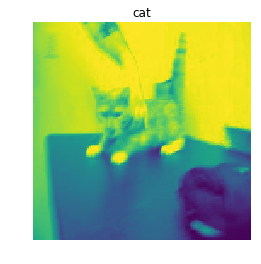

None


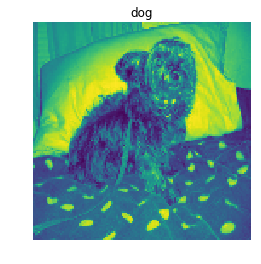

None
Shape:  (2000, 128, 128, 3)
0 Train accuracy:0.62000, Training Loss= 0.637808
Testing Accuracy: 0.58000
1 Train accuracy:0.74000, Training Loss= 0.529760
Testing Accuracy: 0.64250
2 Train accuracy:0.82000, Training Loss= 0.342089
Testing Accuracy: 0.67000
3 Train accuracy:0.88000, Training Loss= 0.301659
Testing Accuracy: 0.56750
4 Train accuracy:0.92000, Training Loss= 0.227458
Testing Accuracy: 0.68250
5 Train accuracy:1.00000, Training Loss= 0.110980
Testing Accuracy: 0.65250
6 Train accuracy:1.00000, Training Loss= 0.062604
Testing Accuracy: 0.66250
7 Train accuracy:1.00000, Training Loss= 0.030006
Testing Accuracy: 0.68750
8 Train accuracy:1.00000, Training Loss= 0.023945
Testing Accuracy: 0.68000
9 Train accuracy:1.00000, Training Loss= 0.039627
Testing Accuracy: 0.67750
10 Train accuracy:1.00000, Training Loss= 0.043929
Testing Accuracy: 0.66000
11 Train accuracy:0.98000, Training Loss= 0.080872
Testing Accuracy: 0.60750
12 Train accuracy:1.00000, Training Loss= 0.032093
Te

In [135]:
#Model 4 using cats and dogs Color 128x128
filepath_cats = 'cats_dogs_64-128/cats_1000_128_128_3.npy'
filepath_dog = 'cats_dogs_64-128/dogs_1000_128_128_3.npy'
imagetype = 'color'

X_train, X_test, y_train, y_test, height, width ,channels = read_image_files(catsfile = filepath_cats, dogsfile = filepath_dog, imagetype = imagetype)

n_inputs = height * width * channels
n_outputs = 2

conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps*64*4*4

n_fc1 = 128


reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

# define variables
tf.InteractiveSession()


with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]  
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})       
        print(epoch, "Train accuracy:" +  "{:.5f}".format(acc_train) + ", Training Loss= " + "{:.6f}".format(loss_train))
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Testing Accuracy:","{:.5f}".format(acc_test))

    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    train_accuracy.append(acc_train)
    train_loss.append(loss_train)
    test_accuracy.append(acc_test)
    data_set.append('Color_128x128')


In [136]:
# aggregate the results for final report
# using OrderedDict to preserve the order of variables in DataFrame    
import pandas as pd
from collections import OrderedDict  

results = pd.DataFrame(OrderedDict([('Data Set', data_set),
                       ('Training Set Accuracy', train_accuracy),
                        ('Test Set Accuracy', test_accuracy)]))

print('\n Experiment: CNN Modles for 2x2 (size and color) \n')
print(results)    


 Experiment: CNN Modles for 2x2 (size and color) 

        Data Set  Training Set Accuracy  Test Set Accuracy
0     Gray_64x64                    1.0             0.6450
1    Color_64x64                    1.0             0.6850
2   Gray_128x128                    1.0             0.6625
3  Color_128x128                    1.0             0.6650
